In [43]:
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import shap
import matplotlib.pyplot as plt
import plotly.express as px
from functions import redshift_connection, create_redshift_df, train_evaluate_model, calculate_mean_shap_values
from sklearn.metrics import accuracy_score, confusion_matrix

In [44]:
results = redshift_connection()
df_redshift_data_all = create_redshift_df(results)

Connection to Redshift database successful
Database connection is active.
Redshift connection closed


In [45]:
df_redshift_data_all.to_csv('redshift_data.csv', index=False)

In [46]:
df_redshift_data_all.shape

(302, 27)

In [47]:
df_redshift_data_all_clean = df_redshift_data_all.dropna()

In [48]:
df_redshift_data_all_clean.shape

(230, 27)

In [49]:
df_redshift_data_all_clean.head()


,fixture_mid,home_team,away_team,home_score,away_score,team_name,kick_errors,rucks_won,rucks_lost,total_linebreaks,...,total_offloads,total_carries,total_carry_metres,total_carries_dominant,total_turnovers_conceded,total_penalties_conceded,total_carry_metres_post_contact,ruck_arrivals_attack_first2,ruck_arrivals_defence_first2,won_lost
0,04c6ed4c-557e-4b58-9309-5ec41be283a0,Edinburgh Rugby,Lions,17,16,Edinburgh Rugby,2,60,6,9,...,7,93,463,52,11,11,263.0,120,36,1
1,04c6ed4c-557e-4b58-9309-5ec41be283a0,Edinburgh Rugby,Lions,17,16,Lions,0,111,3,2,...,6,144,449,89,10,10,318.0,209,27,0
2,06d5af27-8e45-47dc-90ec-df5bf4edf799,Benetton Rugby,Dragons RFC,36,19,Benetton Rugby,0,86,3,10,...,13,129,532,25,19,5,244.0,0,0,1
3,06d5af27-8e45-47dc-90ec-df5bf4edf799,Benetton Rugby,Dragons RFC,36,19,Dragons RFC,2,72,7,4,...,2,98,523,15,14,14,259.0,0,0,0
8,0e4a6cea-3fe4-47d3-840c-fa2d9cf7f043,Ulster Rugby,Leinster Rugby,23,21,Leinster Rugby,2,93,3,3,...,10,129,308,41,21,7,226.0,0,0,0


In [50]:

# df_redshift_data_all = pd.read_csv('redshift_data.csv')
# df_redshift_data_all.shape

In [51]:
df_redshift_data_all_clean['score_difference'] = df_redshift_data_all_clean['home_score'] - df_redshift_data_all_clean['away_score']

# Remove outliers based on the 'score_difference' column
z_scores = np.abs(stats.zscore(df_redshift_data_all_clean['score_difference']))
df_redshift_data_all_clean = df_redshift_data_all_clean[z_scores < 3]

print("\nData after removing outliers:")
print(df_redshift_data_all_clean.describe())
df_redshift_data_all_clean.shape


Data after removing outliers:
       home_score  away_score  kick_errors   rucks_won  rucks_lost  \
count  230.000000  230.000000   230.000000  230.000000  230.000000   
mean    27.217391   20.904348     1.460870   79.660870    3.121739   
std     13.358858    9.381738     1.209763   21.714056    1.803189   
min      3.000000    6.000000     0.000000   24.000000    0.000000   
25%     18.000000   13.250000     1.000000   64.000000    2.000000   
50%     24.000000   20.000000     1.000000   79.000000    3.000000   
75%     34.000000   26.750000     2.000000   94.000000    4.000000   
max     63.000000   54.000000     6.000000  143.000000    9.000000   

       total_linebreaks  total_tries  total_supported_breaks  \
count        230.000000   230.000000              230.000000   
mean           5.360870     3.039130                2.434783   
std            2.897859     1.952099                2.301055   
min            0.000000     0.000000                0.000000   
25%            3.0

/var/folders/k6/bvlj1nxn7zl36cxxh4_5xw7m0000gq/T/ipykernel_39913/3458721027.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_redshift_data_all_clean['score_difference'] = df_redshift_data_all_clean['home_score'] - df_redshift_data_all_clean['away_score']


(230, 28)

In [52]:
# Define the features and target variable
X = df_redshift_data_all_clean[['kick_errors',
            'rucks_won',
            'rucks_lost',
            'total_linebreaks',
            'total_tries',
            'total_supported_breaks',
            'total_defenders_beaten',
            'total_jackals_success',
            'total_intercepts',
            'total_tackles_made',
            'total_tackles_missed',
            'total_offloads',
            'total_carries',
            'total_carry_metres',
            'total_carries_dominant',
            'total_turnovers_conceded',
            'total_penalties_conceded', 
            'total_carry_metres_post_contact',
            'ruck_arrivals_attack_first2',
            'ruck_arrivals_defence_first2']]
y = df_redshift_data_all_clean['won_lost']

# Splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scaling the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

Random forest

In [53]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100)
rf, accuracy_rf, conf_matrix_rf, feature_importance_rf = train_evaluate_model(rf_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)

# Create a DataFrame for feature importance
random_forest_feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'importance_rf': rf.feature_importances_  # Use feature_importances_ for RandomForestClassifier
})

print("Random Forest Accuracy:", accuracy_rf)
print(feature_importance_rf)
random_forest_feature_importance_df.head()



Feature importance found
Random Forest Accuracy: 0.7391304347826086
                            feature  importance
0                       kick_errors    0.019821
1                         rucks_won    0.049180
2                        rucks_lost    0.034212
3                  total_linebreaks    0.096432
4                       total_tries    0.143990
5            total_supported_breaks    0.025940
6            total_defenders_beaten    0.042975
7             total_jackals_success    0.031035
8                  total_intercepts    0.011204
9                total_tackles_made    0.054399
10             total_tackles_missed    0.064873
11                   total_offloads    0.041542
12                    total_carries    0.043921
13               total_carry_metres    0.089271
14           total_carries_dominant    0.061659
15         total_turnovers_conceded    0.039467
16         total_penalties_conceded    0.057075
17  total_carry_metres_post_contact    0.065105
18      ruck_arrival

,feature,importance_rf
0,kick_errors,0.019821
1,rucks_won,0.049180
2,rucks_lost,0.034212
3,total_linebreaks,0.096432
4,total_tries,0.143990


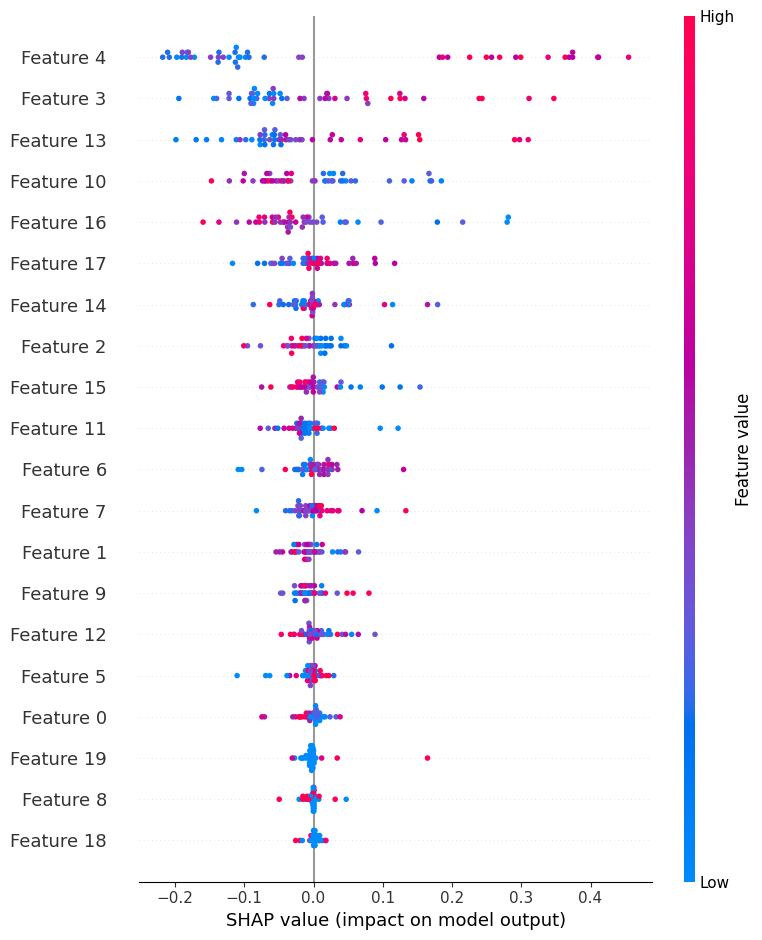

Mean SHAP values for each feature:
kick_errors: -0.0028
rucks_won: -0.0048
rucks_lost: -0.0038
total_linebreaks: -0.0004
total_tries: 0.0276
total_supported_breaks: -0.0078
total_defenders_beaten: -0.0013
total_jackals_success: 0.0009
total_intercepts: -0.0016
total_tackles_made: -0.0052
total_tackles_missed: 0.0006
total_offloads: -0.0077
total_carries: 0.0046
total_carry_metres: -0.0103
total_carries_dominant: 0.0069
total_turnovers_conceded: 0.0059
total_penalties_conceded: -0.0087
total_carry_metres_post_contact: -0.0032
ruck_arrivals_attack_first2: 0.0011
ruck_arrivals_defence_first2: -0.0002


In [54]:
# Create the SHAP Explainer
explainer = shap.Explainer(rf_model.predict, X_train_scaled)

# Calculate SHAP values for test set
shap_values = explainer(X_test_scaled)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test_scaled)

# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(shap_values.values, axis=0)
mean_shap_per_feature = dict(zip(X.columns, mean_shap_values))

print("Mean SHAP values for each feature:")
for feature, mean_shap in mean_shap_per_feature.items():
    print(f"{feature}: {mean_shap:.4f}")

Logistic Regression

In [55]:
# Logistic Regression
lr_model = LogisticRegression()
lr, accuracy_lr, conf_matrix_lr, feature_importance_lr = train_evaluate_model(lr_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)
print("Logistic Regression Accuracy:", accuracy_lr)
print(feature_importance_lr.head(15))

log_regrssion_feature_importance_df = pd.DataFrame({
    'feature': X.columns,
    'coef_lr': lr.coef_[0]
})
log_regrssion_feature_importance_df.head()


Coef found
Logistic Regression Accuracy: 0.6739130434782609
                   feature      coef
0              kick_errors -0.087914
1                rucks_won -0.018528
2               rucks_lost -0.135188
3         total_linebreaks  0.268324
4              total_tries  1.088744
5   total_supported_breaks -0.193893
6   total_defenders_beaten -0.177831
7    total_jackals_success  0.341888
8         total_intercepts  0.092446
9       total_tackles_made -0.089244
10    total_tackles_missed -0.597931
11          total_offloads -0.218503
12           total_carries -0.441252
13      total_carry_metres  1.095958
14  total_carries_dominant -0.183335


,feature,coef_lr
0,kick_errors,-0.087914
1,rucks_won,-0.018528
2,rucks_lost,-0.135188
3,total_linebreaks,0.268324
4,total_tries,1.088744


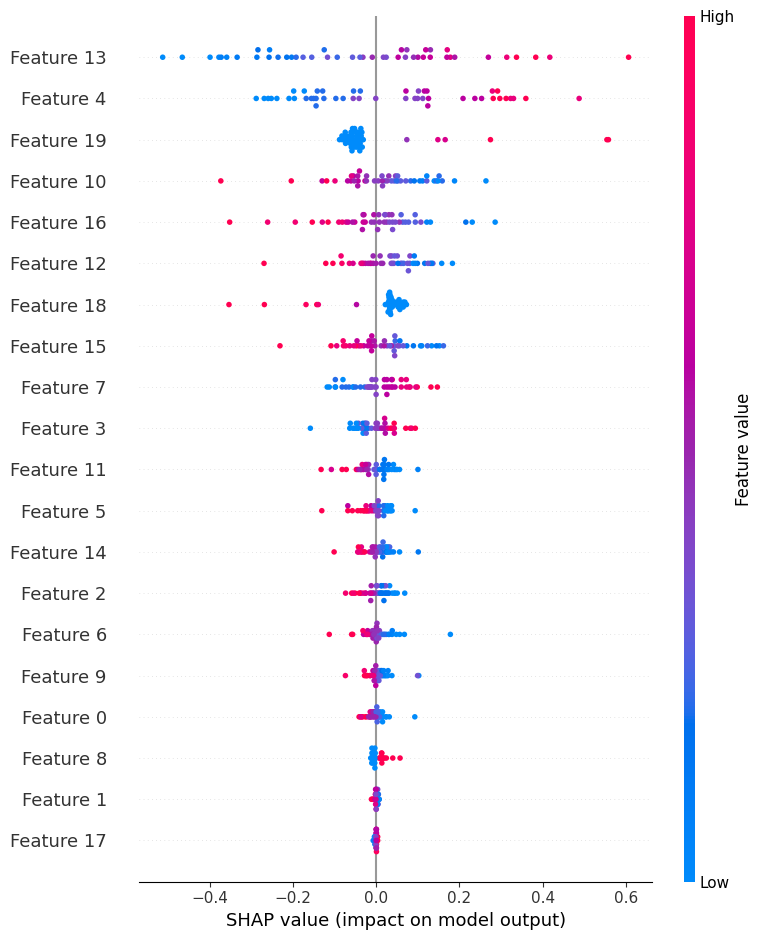

Mean SHAP values for each feature:
kick_errors: -0.0009
rucks_won: 0.0008
rucks_lost: 0.0024
total_linebreaks: -0.0041
total_tries: 0.0238
total_supported_breaks: -0.0022
total_defenders_beaten: 0.0037
total_jackals_success: 0.0020
total_intercepts: 0.0022
total_tackles_made: 0.0053
total_tackles_missed: 0.0195
total_offloads: -0.0028
total_carries: 0.0275
total_carry_metres: -0.0333
total_carries_dominant: 0.0032
total_turnovers_conceded: 0.0132
total_penalties_conceded: 0.0032
total_carry_metres_post_contact: -0.0005
ruck_arrivals_attack_first2: 0.0135
ruck_arrivals_defence_first2: -0.0085


In [56]:
# Create the SHAP Explainer
explainer = shap.Explainer(lr_model.predict, X_train_scaled)

# Calculate SHAP values for test set
shap_values = explainer(X_test_scaled)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test_scaled)

# Calculate mean SHAP values for each feature
mean_shap_values = np.mean(shap_values.values, axis=0)
mean_shap_per_feature = dict(zip(X.columns, mean_shap_values))

print("Mean SHAP values for each feature:")
for feature, mean_shap in mean_shap_per_feature.items():
    print(f"{feature}: {mean_shap:.4f}")

XgBoost

In [57]:

import xgboost as xgb# Initialize XGBoost classifier
xgb_classifier = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')

# Train the model
xgb_classifier.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = xgb_classifier.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Print the results
print("XGBClassifier Accuracy:", accuracy)
print("Confusion Matrix:\n", conf_matrix)

# Feature importance
xgboost_feature_importance = pd.DataFrame({'feature': X.columns, 'importance_xgb': xgb_classifier.feature_importances_})
print("Feature Importance:\n", xgboost_feature_importance.sort_values(by='importance_xgb', ascending=False))

XGBClassifier Accuracy: 0.8478260869565217
Confusion Matrix:
 [[16  3]
 [ 4 23]]
Feature Importance:
                             feature  importance_xgb
4                       total_tries        0.284997
10             total_tackles_missed        0.095154
19     ruck_arrivals_defence_first2        0.057248
3                  total_linebreaks        0.056491
12                    total_carries        0.050124
2                        rucks_lost        0.044521
15         total_turnovers_conceded        0.043356
7             total_jackals_success        0.042035
14           total_carries_dominant        0.040360
9                total_tackles_made        0.039587
17  total_carry_metres_post_contact        0.037700
1                         rucks_won        0.037626
16         total_penalties_conceded        0.036602
6            total_defenders_beaten        0.034833
13               total_carry_metres        0.030599
5            total_supported_breaks        0.023262
11            

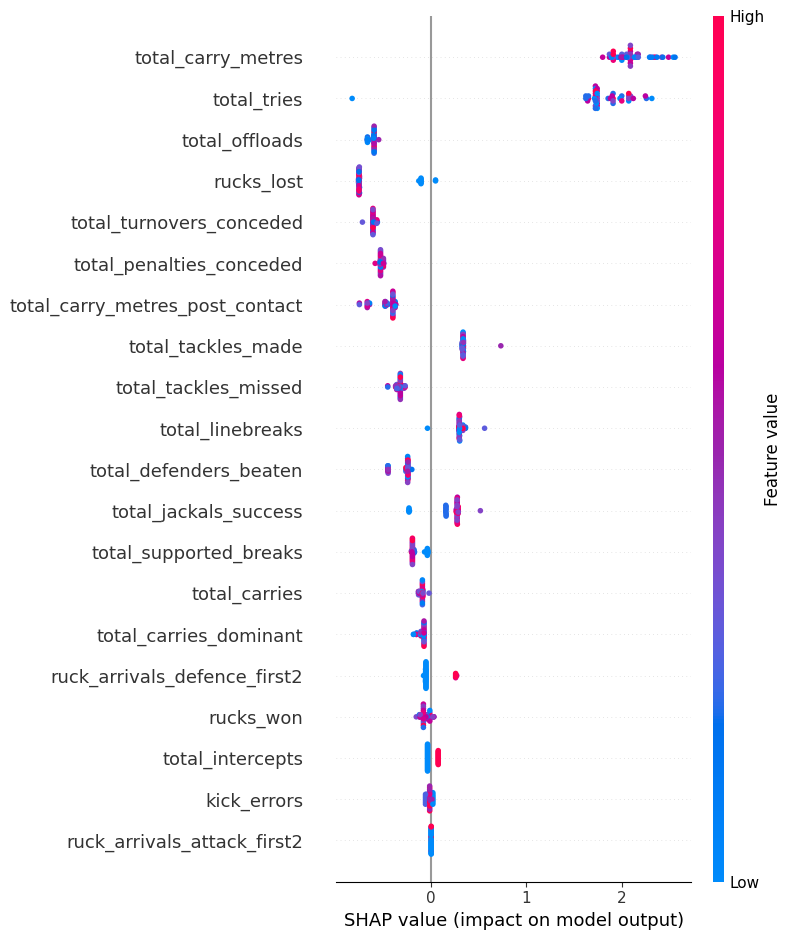

Mean SHAP values for each feature:
kick_errors: -0.0175
rucks_won: -0.0578
rucks_lost: -0.6101
total_linebreaks: 0.3067
total_tries: 1.8026
total_supported_breaks: -0.1551
total_defenders_beaten: -0.2865
total_jackals_success: 0.2006
total_intercepts: 0.0007
total_tackles_made: 0.3419
total_tackles_missed: -0.3360
total_offloads: -0.6150
total_carries: -0.1022
total_carry_metres: 2.1186
total_carries_dominant: -0.0952
total_turnovers_conceded: -0.6077
total_penalties_conceded: -0.5248
total_carry_metres_post_contact: -0.4733
ruck_arrivals_attack_first2: 0.0000
ruck_arrivals_defence_first2: -0.0158


In [58]:
# Create the SHAP Explainer
explainer = shap.Explainer(xgb_classifier)

# Calculate SHAP values for test set
shap_values = explainer(X_test)

# Summarize the effects of all the features
shap.summary_plot(shap_values, X_test)

mean_shap_values = np.mean(shap_values.values, axis=0)
mean_shap_per_feature = dict(zip(X_test.columns, mean_shap_values))
print("Mean SHAP values for each feature:")
for feature, mean_shap in mean_shap_per_feature.items():
    print(f"{feature}: {mean_shap:.4f}")



In [59]:
# from sklearn.svm import SVC
# # from sklearn.neural_network import MLPClassifier

# # SVM with a linear kernel
# svm_model = SVC(kernel='linear')
# svm, accuracy_svm, conf_matrix_svm, feature_importance_svm = train_evaluate_model(svm_model, X_train_scaled, y_train, X_test_scaled, y_test, feature_names=X.columns)

# # # MLP Neural Network
# # mlp_model = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300)
# # mlp, accuracy_mlp, conf_matrix_mlp, _ = train_evaluate_model(mlp_model, X_train_scaled, y_train, X_test_scaled, y_test)
 
# print("SVM Accuracy:", accuracy_svm)
# print(feature_importance_svm)
# # print("MLP Neural Network Accuracy:", accuracy_mlp)
# # print( _ )

In [60]:
# Merge the DataFrames on the 'feature' column
merged_df = log_regrssion_feature_importance_df.merge(random_forest_feature_importance_df, on='feature')
merged_df = merged_df.merge(xgboost_feature_importance, on='feature')
merged_df.to_csv('output/feature_importance_merged.csv', index=False)

